# Try to upload `rho_lap` term

In [5]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [6]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.4e11198501c94296b228f58a8fddf86a/status,


In [71]:
cluster.close()
client.close()

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba, rho
import fastjmd95
import pop_tools
import gcsfs
import gcm_filters
import xgcm
from typing import Annotated
#import gsw

In [2]:
from intake import open_catalog

url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/GFDL_CM2.6.yaml"
cat = open_catalog(url)
ds  = cat["GFDL_CM2_6_control_ocean"].to_dask()
surf_ds  = cat["GFDL_CM2_6_control_ocean_surface"].to_dask()
coord  = cat["GFDL_CM2_6_grid"].to_dask()

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [3]:
sst = surf_ds.surface_temp
sss = surf_ds.surface_salt

In [4]:
rho = fastjmd95.rho(sss, sst, 0)

In [7]:
rho

<xarray.DataArray (time: 7305, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<transpose, shape=(7305, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [10]:
rho_ds.rho_test

<xarray.DataArray 'rho_test' (time: 7305, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<transpose, shape=(7305, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98

In [8]:
rho_ds = rho.to_dataset(name='rho_test')

In [25]:
rho_ds1 = rho.to_dataset(name='rho')

In [28]:
rho_imported = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))

In [29]:
rho_imported1 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_term.zarr'))

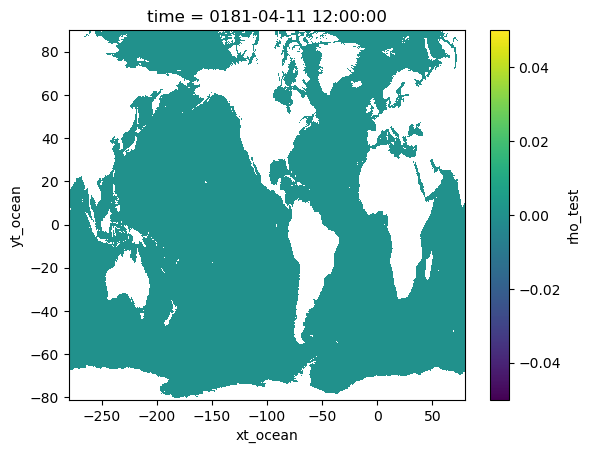

In [21]:
(rho_ds.rho_test - rho_imported.rho_test).isel(time=100).plot();

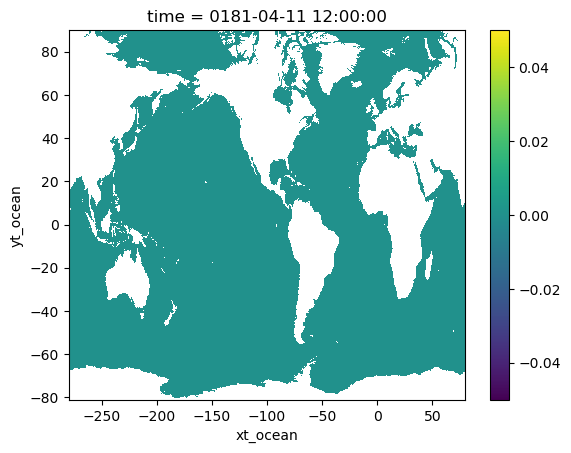

In [30]:
(rho_ds.rho_test - rho_imported1.rho).isel(time=100).plot();

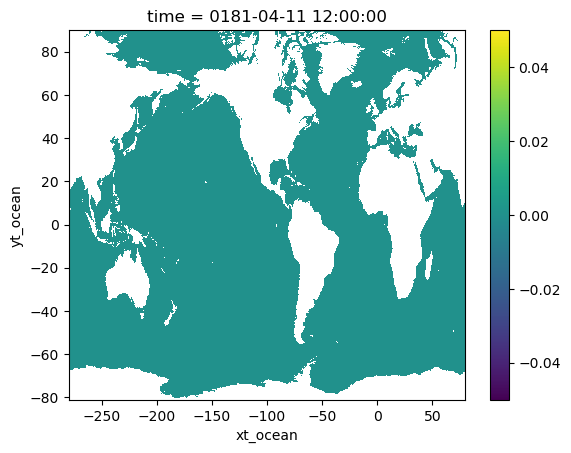

In [11]:
(rho - rho_ds.rho_test).isel(time=100).plot();

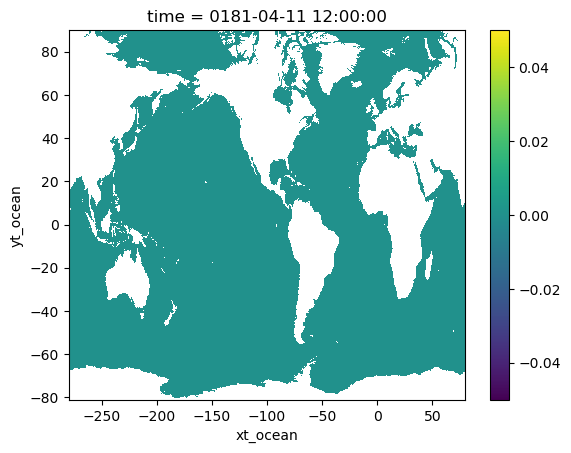

In [22]:
(rho - rho_imported.rho_test).isel(time=100).plot();

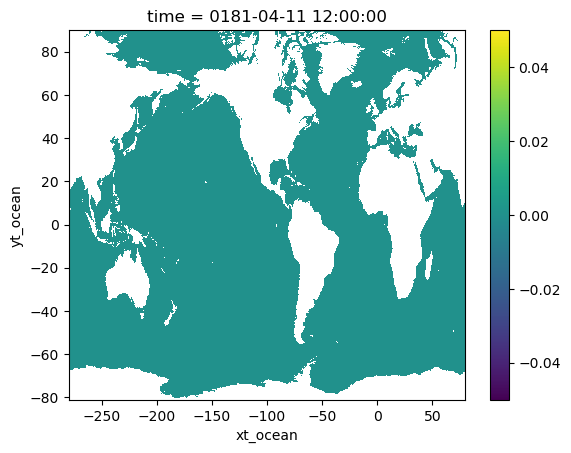

In [31]:
(rho - rho_imported1.rho).isel(time=100).plot();

In [12]:
import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [23]:
#uploading rho_lap tendency ds first half
gcsmap_rho_lap = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr')
rho_ds.to_zarr(gcsmap_rho_lap, mode='w')

In [24]:
client.restart()

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.4e11198501c94296b228f58a8fddf86a/status,


In [26]:
#uploading rho_lap tendency ds first half
gcsmap_rho_lap = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_term.zarr')
rho_ds1.to_zarr(gcsmap_rho_lap, mode='w')

## Laplacian routine

In [32]:
wet_mask = coord.wet
dxt = coord.dxt
dyt = coord.dyt
dxu = coord.dxu
dyu = coord.dyu
area_t = coord.area_t
kappa = 10 #m^2/s

In [33]:
grid = xgcm.Grid(ds.drop_dims('time'), coords={'X': {'center': 'xt_ocean', 'right': 'xu_ocean'},
                        'Y': {'center': 'yt_ocean', 'right': 'yu_ocean'},
                        'Z': {'inner': 'st_ocean', 'outer': 'st_edges_ocean'} }, periodic=['X'])

In [34]:
@xgcm.as_grid_ufunc(dask="parallelized")
def Laplacian(
    wet_mask: Annotated[np.ndarray, "(Y:center, X:center)"],
    dxt:      Annotated[np.ndarray, "(Y:center, X:center)"],
    dyt:      Annotated[np.ndarray, "(Y:center, X:center)"],
    area_t:   Annotated[np.ndarray, "(Y:center, X:center)"],
    tracer:   Annotated[np.ndarray, "(Y:center, X:center)"],
    dxu:      Annotated[np.ndarray, "(Y:right, X:right)"],
    dyu:      Annotated[np.ndarray, "(Y:right, X:right)"],
) ->          Annotated[np.ndarray, "(Y:center, X:center)"]:
    
    """Laplacian for MOM5 (tracer points).
    MOM5 uses a Northeast convention B-grid, where velocity point U(i,j) is NE of tracer point T(i,j).
    Attributes
    __________
    For information on MOM5 discretization see: https://mom-ocean.github.io/assets/pdfs/MOM5_manual.pdf
    wet_mask: Mask array, 1 for ocean, 0 for land
    dxt: width in x of T-cell, model diagnostic dxt
    dyt: height in y of T-cell, model diagnostic dyt
    dxu: width in x of U-cell, model diagnostic dxu
    dyu: height in y of U-cell, model diagnostic dyu
    area_t: area of T-cell, dxt*dyt
    """    
    #x_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-1)
    #y_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-2)
    y_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-1)
    x_wet_mask = wet_mask * np.roll(wet_mask, -1, axis=-2)

    tracer = np.nan_to_num(tracer)
    
    fx = 2 * (np.roll(tracer, -1, axis=-2) - tracer)
    fx /= dxu + np.roll(dxu, 1, axis=-1)
    fx *= x_wet_mask
    
    fy = 2 * (np.roll(tracer, -1, axis=-1) - tracer)
    fy /= dyu + np.roll(dyu, 1, axis=-2)
    fy *= y_wet_mask

    out1 = fx * 0.5 * (dyt + np.roll(dyt, -1, axis=-2))
    out1 -= (
        np.roll(fx, 1, axis=-2) * 0.5 * (dyt + np.roll(dyt, 1, axis=-2))
    )
    out1 /= area_t

    out2 = fy * 0.5 * (dxt + np.roll(dxt, -1, axis=-1))
    out2 -= (
        np.roll(fy, 1, axis=-1) * 0.5 * (dxt + np.roll(dxt, 1, axis=-1))
    )
    out2 /= area_t
    return out1 + out2

In [35]:
axis = 7*[('Y','X')]

# Define `rho_lap`

In [36]:
rho_lap_outliers = kappa * Laplacian(grid, wet_mask, dxt, dyt, area_t, rho_imported1.rho, dxu, dyu, axis=axis)

rho_lap_outliers

<xarray.DataArray (time: 7305, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<mul, shape=(7305, 2700, 3600), dtype=float64, chunksize=(1, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>

In [37]:
rho_lap = rho_lap_outliers.where(abs(rho_lap_outliers) < 3e-7)

In [38]:
tracers = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/tracer_tendencies.zarr'))
#drhodts = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/drhodts_tendencies.zarr'))
#rho = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho.zarr'))
cab = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/cabbeling.zarr'))
#rho_lap = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_laplacian.zarr'))

tendencies = xr.merge([tracers, cab])#, drhodts, rho_lap])

In [39]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    SSS_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    SST_lap    (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    cabbeling  (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>

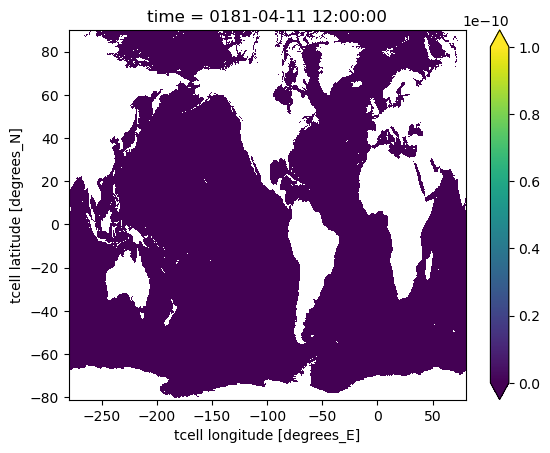

In [40]:
(rho_lap - tendencies.SST_lap - tendencies.SSS_lap + tendencies.cabbeling).isel(time=100).plot(robust=True, vmin=1e-10);

In [42]:
rho_lap_ds = rho_lap.to_dataset(name='rho_lap')

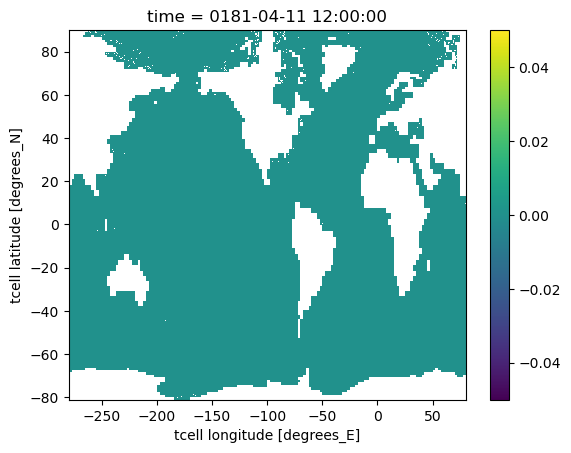

In [45]:
(rho_lap - rho_lap_ds.rho_lap)[100].plot(robust=True)

In [46]:
#uploading rho_lap_ds tendency ds for entire 40 yr run
gcsmap_rho_lap_tendencies = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_lap.zarr')
rho_lap_ds.to_zarr(gcsmap_rho_lap_tendencies, mode='w')

In [47]:
rho_lap_imported = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CM2_6/datasets/surf_ds/rho_lap.zarr'))

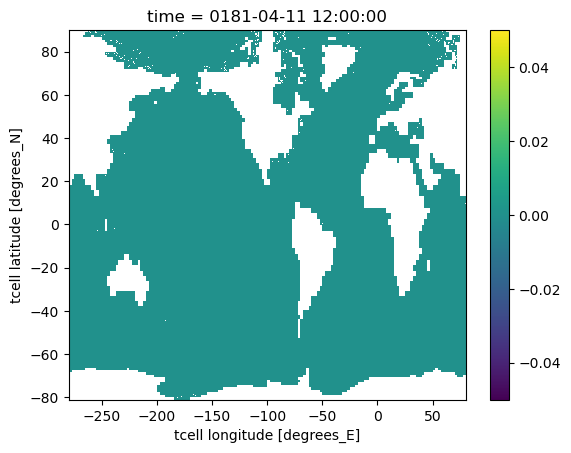

In [51]:
(rho_lap - rho_lap_imported.rho_lap).isel(time=100).plot(robust=True);

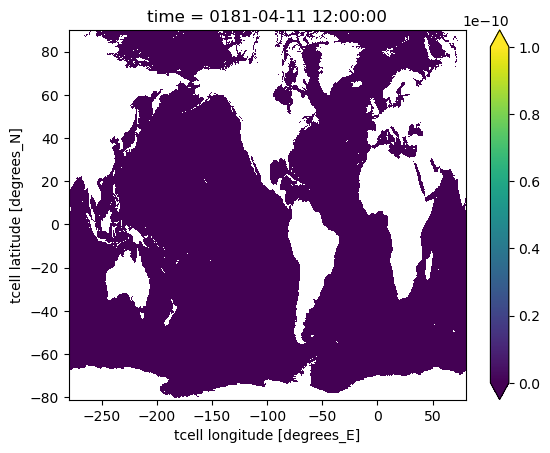

In [52]:
(rho_lap_imported.rho_lap - tendencies.SST_lap - 
 tendencies.SSS_lap + tendencies.cabbeling).isel(time=100).plot(robust=True, vmin=1e-10);